In [243]:
#PF Optimization - EMT
import numpy as np
from numpy import array
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

import yfinance as yf

In [244]:
def GetNSEData(StockName,strt_date,end_date):
    stk_name = StockName+ '.NS'                                #Add suffix as '.BO' if we want a BSE data
    data = yf.download(stk_name,start=strt_date, end=end_date)
    return data

In [288]:
df = GetNSEData('PIDILITIND',"2015-03-26","2021-03-26")
#df

[*********************100%***********************]  1 of 1 completed


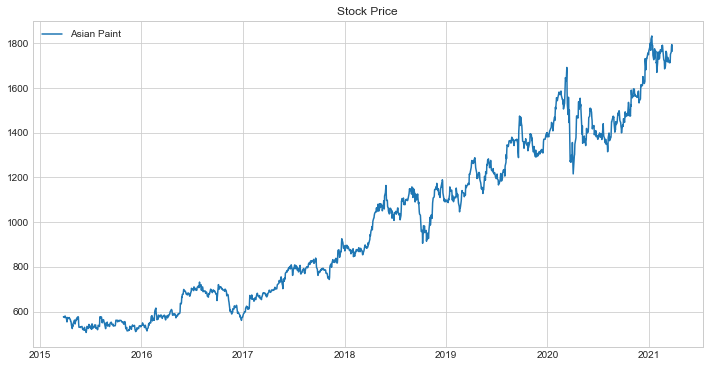

In [289]:
# Plot the price of the asset over time
plt.figure(figsize=(12,6))
plt.title('Stock Price')
plt.plot(df['Adj Close'],label = 'Asian Paint' )
plt.legend(loc='upper left')
plt.show()

In [290]:
#CAGR - Compounded annual growth rate, calculate R using C = P(1+R/100)^t
P = df['Adj Close'].iloc[0]
C = df['Adj Close'].iloc[-1]

CAGR = (C/P)**(1/5) - 1

Abs_Ret = (C-P)/P

print('CAGR for stock in 5 years: ' + str(round(CAGR,1)*100)+'%')
print('Absolute return for stock in 5 years: ' + str(round(Abs_Ret,2)*100)+'%')

CAGR for stock in 5 years: 30.0%
Absolute return for stock in 5 years: 206.0%


In [291]:
#RSI calculation
def TI_RSI_Calc(df):
    df['daily delta']  = df['Close'] - df['Close'].shift(1)
    df['up']   = np.where((df['daily delta'] > 0), df['daily delta'], 0)
    df['down'] = np.where((df['daily delta'] < 0), df['daily delta'], 0)

    up   = df['up'].rolling(14).mean()
    down = df['down'].abs().rolling(14).mean()

    RS = up/down
    RSI = 100 - 100/(1+RS)
    df['RSI'] = round(RSI,1)
    
    #Backtesting logic - go long when RSI < 40 and short on RSI > 60
    LOWER_CUTOFF = 40
    UPPER_CUTOFF = 60

    df['long'] = np.where((df['RSI'] < LOWER_CUTOFF),1,np.nan)
    df['long'] = np.where((df['RSI'] > UPPER_CUTOFF),0,df['long'])
    df['long'].ffill(inplace = True)

    return

In [292]:
TI_RSI_Calc(df)

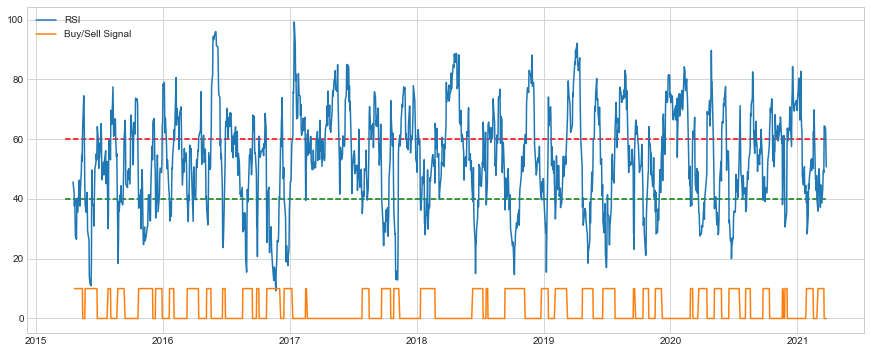

In [293]:
# Plotting RSI and signals

plt.figure(figsize=(15,6))

plt.plot(df['RSI'], label='RSI')

#y = LOWER_CUTOFF, xmin = start date, xmax = end date
plt.hlines(LOWER_CUTOFF, df.index[0], df.index[-1], colors='g', linestyles='dashed')
plt.hlines(UPPER_CUTOFF, df.index[0], df.index[-1], colors='r', linestyles='dashed')

plt.plot(df['long']*10, label='Buy/Sell Signal')    #x15 for magnified view only

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [294]:
def momentum_strategy(data):
           
    buy_price = []
    sell_price = []
    profit = []
    flag = -1 
    first_buy = False
              
    MA = data['Close'].rolling(window=5).mean()
    
    for i in range(len(data)):
        if data['RSI'][i] > UPPER_CUTOFF:        
            if flag != 1 and first_buy == True:
                    buy_price.append(np.nan)
                    sell_price.append(data['Close'][i]) 
                    temp = (data['Close'][i] - last_buy)/last_buy
                    #print(temp)
                    profit.append(temp*100) 
                    flag = 1  
                    #print("Sell Price: ",data['Close Price'][i])
                    #print("Sell Date: ",data.iloc[i].name)
                    #print("Sell RSI: ",data['RSI'][i])
            else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    profit.append(np.nan)
        elif data['RSI'][i] < LOWER_CUTOFF:        
            if flag != 0:
                    buy_price.append(data['Close'][i])
                    sell_price.append(np.nan) 
                    profit.append(np.nan)
                    first_buy = True
                    last_buy = data['Close'][i]
                    #print("\nBuy Price: ",data['Close Price'][i])
                    #print("Buy Date: ",data.iloc[i].name) 
                    #print("Buy RSI: ",data['RSI'][i])
                    flag = 0                    
            else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan) 
                    profit.append(np.nan)
        else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    profit.append(np.nan)
                         
    return(buy_price,sell_price,profit)

In [295]:
trade = momentum_strategy(df)

df['Buy_Price']  = trade[0]
df['Sell_Price'] = trade[1]
df['Profit']     = trade[2]

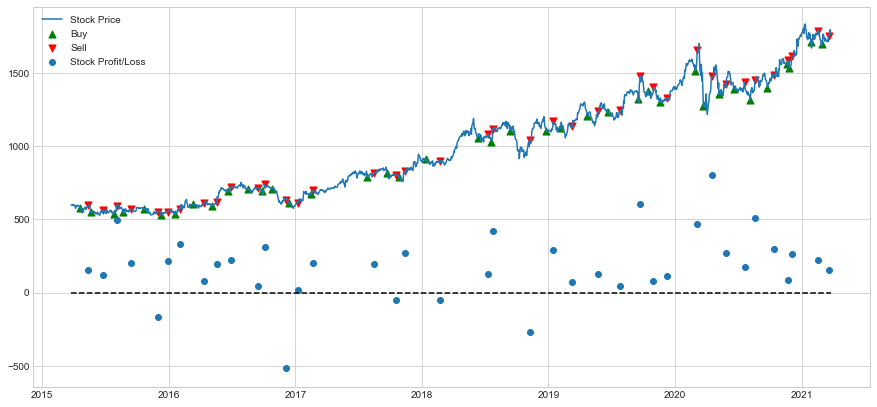

In [296]:
# Plotting the NIFTY Price Series chart and Moving Averages below
plt.figure(figsize=(15,7))
plt.plot(df['Close'], label='Stock Price')

plt.scatter(df.index,df['Buy_Price'], label = 'Buy', marker = '^',color = 'green',s=50)
plt.scatter(df.index,df['Sell_Price'],label = 'Sell',marker = 'v',color = 'red',s=50)
plt.scatter(df.index,df['Profit']*50, label='Stock Profit/Loss')
plt.hlines(0, df.index[0], df.index[-1], colors='black', linestyles='dashed')

plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

In [299]:
gain = df['Profit'].sum() 
print('Total trading profit : ',str(round(gain,1))+'%') 
print('Total number of trades : ',df['Profit'].count()) 

Total trading profit :  142.8%
Total number of trades :  39


In [306]:
temp = df[df['Profit'].isnull() != True].loc['2019'] 
print(temp['Profit'])
print('Total trading profit and trades : ', str(round(temp['Profit'].sum(),1) ) + '%') 

Date
2019-01-10    7.405147
2019-03-11    2.971058
2019-08-27    2.252150
2019-12-05    2.434913
Name: Profit, dtype: float64
Total trading profit and trades :  15.1%


In [309]:
#get the data from the NSE directly for last 5 years
df = GetNSEData('KOTAKBANK',"2015-03-26","2021-03-26")

# Calculate RSI 
TI_RSI_Calc(df)

#Execute a strategy 
trade = momentum_strategy(df)

#Check the profits 
df['Profit']     = trade[2]
gain = df['Profit'].sum() 
print('Total trading profit : ',str(round(gain,1))+'%') 
print('Total number of trades : ',df['Profit'].count())

[*********************100%***********************]  1 of 1 completed
Total trading profit :  67.9%
Total number of trades :  29


In [168]:
def Get_RSI(df):
    df['MA200'] = df['Adj Close'].rolling(window=200).mean()
    df['Price Change'] = df['Adj Close'].pct_change()
    df['Upmove'] = df['Price Change'].apply(lambda x: x if x > 0 else 0 )
    df['Downmove'] = df['Price Change'].apply(lambda x: abs(x) if x < 0 else 0 )
    df['Avg Up'] = df['Upmove'].ewm(span=19).mean()
    df['Down Up'] = df['Downmove'].ewm(span=19).mean()
    df['RS'] = df['Avg Up'] / df['Down Up']
    df['RSI'] = df['RS'].apply(lambda x: 100 - (100/(x+1)))
    #df = df.dropna()
    
    df.loc[(df['Adj Close'] > df['MA200']) & (df['RSI'] < 30),'Buy'] = 1
    df.loc[(df['Adj Close'] < df['MA200']) | (df['RSI'] > 30),'Buy'] = 0
    return

In [238]:
def Generate_Signal(df):
    buy_data = []
    sell_data = []
    profit = []
    
    for i in range(len(df)):
        if df['Buy'].iloc[i] == 1:
            buy_data.append(df['Adj Close'].iloc[i+1]) 
            for j in range (1,11):
                if df['RSI'].iloc[i+j] > 50:
                    sell_data.append(df['Adj Close'].iloc[i+j+1])
                    break
                elif j==10:
                    sell_data.append(df['Adj Close'].iloc[i+j+1]) 
            
            x=  df['Adj Close'].iloc[i+j+1]
            y = df['Adj Close'].iloc[i+1]
            z = (x-y)/y
            
            profit.append(z*100)       
        else:
            sell_data.append(np.nan)
            buy_data.append(np.nan)
            profit.append(np.nan)
    
    return buy_data,sell_data,profit

In [241]:
Get_RSI(df)
buy,sell,profit = Generate_Signal(df)

total = 0
for ele in range(0, len(profit)):
    if np.isnan(profit[ele]) == False:
        total = total + profit[ele]
        #print(profit[ele])

total

3.2535315180887903

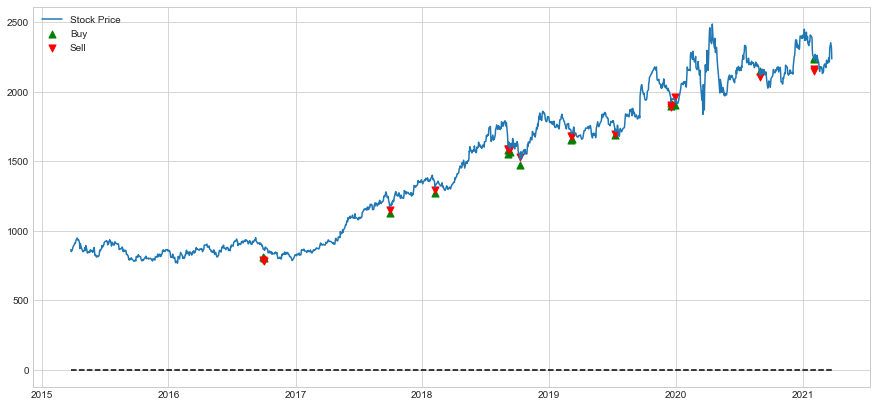

In [240]:
# Plotting the NIFTY Price Series chart and Moving Averages below
plt.figure(figsize=(15,7))
plt.plot(df['Close'], label='Stock Price')

plt.scatter(df.index,buy, label = 'Buy', marker = '^',color = 'green',s=50)
plt.scatter(df.index,sell,label = 'Sell',marker = 'v',color = 'red',s=50)
#plt.scatter(df.index,df['Profit']*50, label='Stock Profit/Loss')
plt.hlines(0, df.index[0], df.index[-1], colors='black', linestyles='dashed')

plt.legend(loc='upper left')
#plt.grid(True)
plt.show()